# `nb01`: Build, compute, critique, repeat

![](./figures/nb01/boxloop.png)

In this course, we will approach data science problems using the scientific method. We will build models, compute results, and critique our work. We will repeat this process until we are satisfied with our results. This process is called the **Box's Loop**. Upcoming lectures will dive into each of these steps in more detail.

# Build 

In [1]:
# Generative model
import numpy as np

def simulate(v, alpha, dt=0.001, G=9.81):
    v_x = v * np.cos(alpha)  # x velocity m/s
    v_y = v * np.sin(alpha)  # y velocity m/s
    
    x = 0.0  # initial position
    y = 1.5  # initial height
    # y = y + np.random.randn() * 0.1
    trajectory = [(x, y)]

    while y > 0:  # simulate until ball hits floor
        v_y += dt * -G  # acceleration due to gravity
        x += dt * v_x
        y += dt * v_y
        trajectory.append((x, y))
        
    return np.array(trajectory)

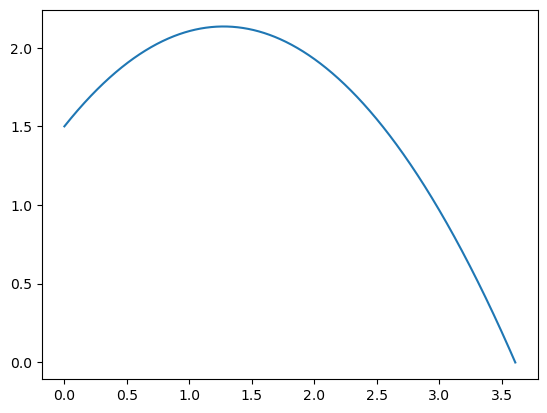

In [2]:
import matplotlib.pyplot as plt

v = 5.0
alpha = np.pi / 4.0

trajectory = simulate(v, alpha)
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()

In [3]:
# Probabilistic model
from scipy.stats import norm, uniform

 # observational model
def likelihood(v, alpha): 
    trajectory = simulate(v, alpha)
    x = trajectory[-1, 0]
    return norm(loc=x, scale=0.5)

# prior model  
p_v = uniform(0., 10.0)    # start with [0,1] and discuss
p_alpha = uniform(0., np.pi / 2)   # start with [-pi;pi]

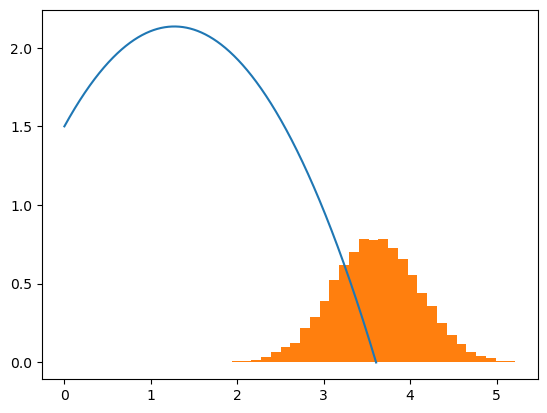

In [4]:
# p(x | v, alpha)
v = 5.0
alpha = np.pi / 4.0

trajectory = simulate(v, alpha)
plt.plot(trajectory[:, 0], trajectory[:, 1])

lk = likelihood(v, alpha)
xs = lk.rvs(10000)
plt.hist(xs, density=True, bins=30)

plt.show()

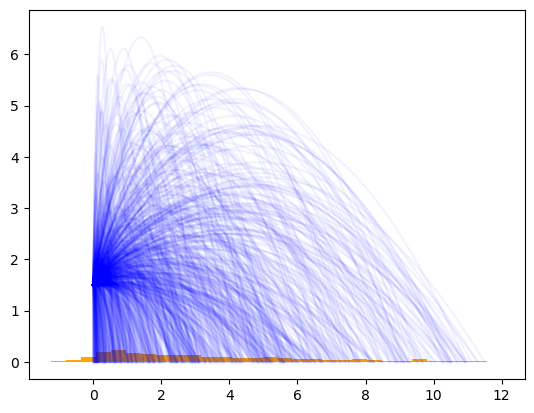

In [5]:
# p(x)
xs = []

for i in range(1000):
    v = p_v.rvs()
    alpha = p_alpha.rvs()
    trajectory = simulate(v, alpha)
    plt.plot(trajectory[:, 0], trajectory[:, 1], color="b", alpha=0.05)
    x = likelihood(v, alpha).rvs()
    xs.append(x)
    
plt.hist(xs, density=True, bins=30, color="orange")
plt.show()

# Data

In [6]:
v_true = 5.0
alpha_true = np.pi / 4
x_obs = likelihood(v_true, alpha_true).rvs()

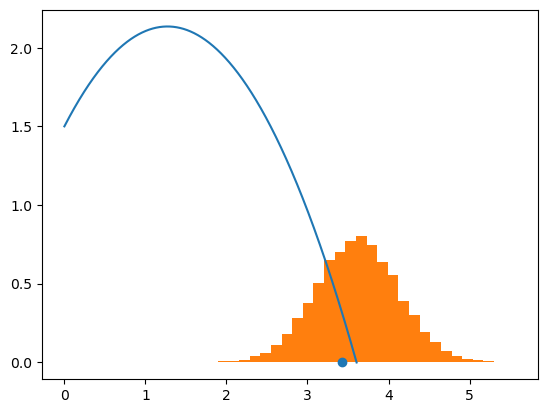

In [7]:
trajectory = simulate(v_true, alpha_true)
plt.plot(trajectory[:, 0], trajectory[:, 1])

lk = likelihood(v_true, alpha_true)
xs = lk.rvs(10000)
plt.hist(xs, density=True, bins=30)
plt.scatter([x_obs], [0.])
plt.show()

# Compute

In [8]:
# Point-valued estimate
from scipy.optimize import minimize

def log_likelihood(theta, x):
    v, alpha = theta
    lk = likelihood(v, alpha)
    return lk.logpdf(x)

nll = lambda *args: -log_likelihood(*args)
initial = np.array([p_v.rvs(), p_alpha.rvs()])
soln = minimize(nll, initial, args=(x_obs,))
soln

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.2257913526447275
        x: [ 6.114e+00  1.171e-02]
      nit: 6
      jac: [-7.451e-09  0.000e+00]
 hess_inv: [[ 7.971e-01  1.679e-03]
            [ 1.679e-03  9.419e-02]]
     nfev: 21
     njev: 7

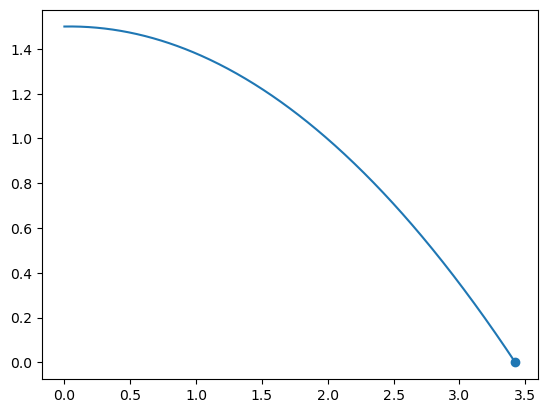

In [9]:
v_sol, alpha_sol = soln.x

trajectory = simulate(v_sol, alpha_sol)
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.scatter([x_obs], [0.])

plt.show()

In [10]:
# Uncertainty estimation
def log_prior(theta):
    v, alpha = theta
    return p_v.logpdf(v) + p_alpha.logpdf(alpha)  
    
def log_posterior(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x)

In [11]:
import emcee

pos = soln.x + 0.1 * np.random.randn(10, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_obs,))
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/home/glouppe/anaconda3/envs/dats0001/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [01:27<00:00, 114.11it/s]


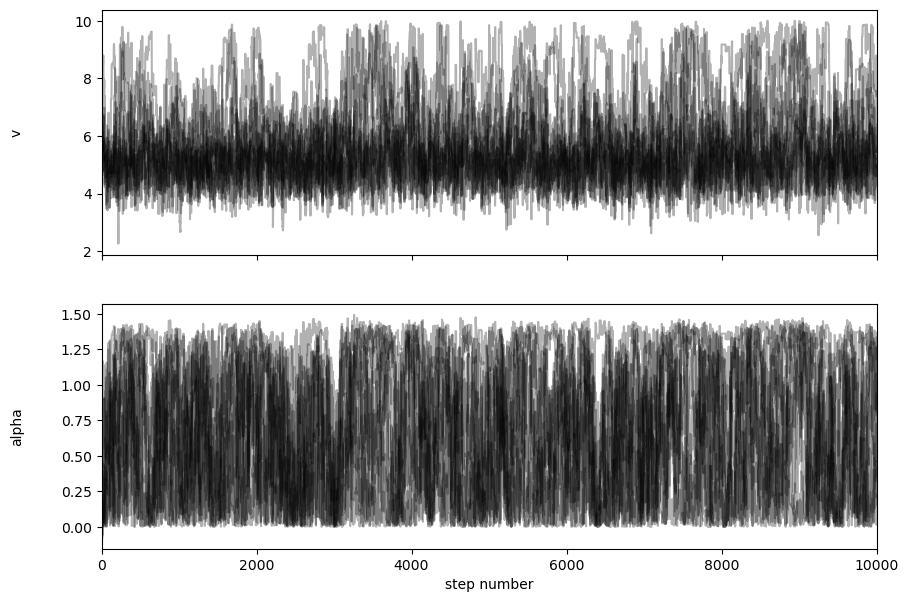

In [12]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["v", "alpha"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

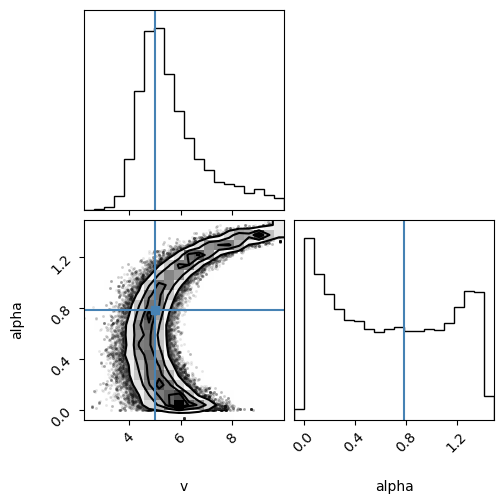

In [13]:
import corner
thetas = sampler.get_chain(flat=True)
fig = corner.corner(thetas, labels=labels, truths=[v_true, alpha_true])

# Critique

In [14]:
# Computational diagnostics 
tau = sampler.get_autocorr_time()
print(tau)

[128.95974176 170.19809673]


In [15]:
thetas = sampler.get_chain(flat=True, discard=200, thin=50)
thetas.shape

(1960, 2)

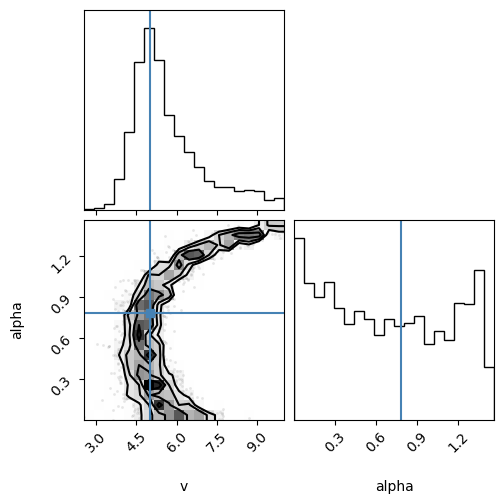

In [16]:
fig = corner.corner(thetas, labels=labels, truths=[v_true, alpha_true])

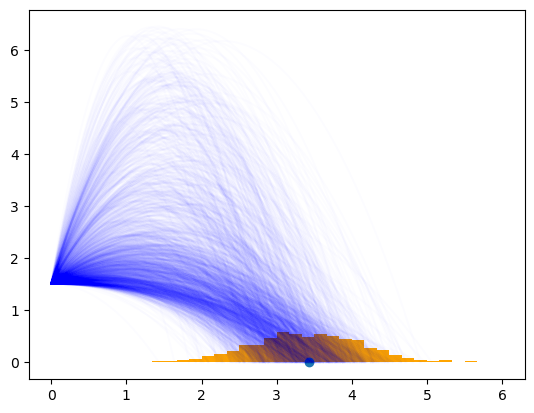

In [17]:
# Posterior predictive checks
# p(x | x_obs)
xs = []
    
for v, alpha in thetas:
    trajectory = simulate(v, alpha)
    plt.plot(trajectory[:, 0], trajectory[:, 1], color="b", alpha=0.01)
    
    x = likelihood(v, alpha).rvs()
    xs.append(x)

plt.hist(xs, density=True, bins=30, color="orange")
plt.scatter([x_obs], [0.])
plt.show()

# Improve and repeat

- What if `x_obs=15`?
- What if the height of the pitcher is unknown?
- What if there is wind? 
- What if, maybe, there is wind?
- How to evaluate and compare models?